Let's go.

In [23]:
import pandas as pd

In [24]:
def openData():
    df=pd.read_csv("../data.csv")
    df.drop_duplicates()
    return df

house=openData()
house.info()
house['age'] = (1403-house['buildYear']) # adding age for better corr
house['price']/=1000000000 # easier control

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   meter      994 non-null    int64  
 1   district   994 non-null    object 
 2   buildYear  994 non-null    int64  
 3   rooms      992 non-null    float64
 4   price      994 non-null    int64  
 5   elevator   994 non-null    int64  
 6   space      994 non-null    int64  
 7   parking    994 non-null    int64  
 8   floor      955 non-null    float64
dtypes: float64(2), int64(6), object(1)
memory usage: 70.0+ KB


just working a bit with the dataset to understand what's going on. you can pass this.

In [25]:
print(house.describe())

            meter    buildYear       rooms       price    elevator  \
count  994.000000   994.000000  992.000000  994.000000  994.000000   
mean    95.944668  1393.168008    1.946573   11.526846    0.781690   
std     52.360359     8.082713    0.736923   15.887352    0.413307   
min      1.000000  1370.000000    1.000000    0.003330    0.000000   
25%     61.000000  1386.000000    1.000000    3.450000    1.000000   
50%     83.000000  1395.000000    2.000000    7.200000    1.000000   
75%    115.000000  1401.000000    2.000000   13.800000    1.000000   
max    650.000000  1403.000000    4.000000  220.000000    1.000000   

            space     parking       floor         age  
count  994.000000  994.000000  955.000000  994.000000  
mean     0.834004    0.933602    3.855497    9.831992  
std      0.372264    0.249103    3.415352    8.082713  
min      0.000000    0.000000    1.000000    0.000000  
25%      1.000000    1.000000    2.000000    2.000000  
50%      1.000000    1.000000    

array([[<AxesSubplot: title={'center': 'meter'}>,
        <AxesSubplot: title={'center': 'buildYear'}>,
        <AxesSubplot: title={'center': 'rooms'}>],
       [<AxesSubplot: title={'center': 'price'}>,
        <AxesSubplot: title={'center': 'elevator'}>,
        <AxesSubplot: title={'center': 'space'}>],
       [<AxesSubplot: title={'center': 'parking'}>,
        <AxesSubplot: title={'center': 'floor'}>,
        <AxesSubplot: title={'center': 'age'}>]], dtype=object)

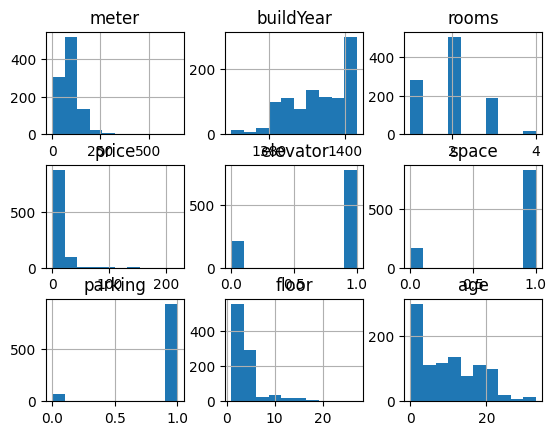

In [26]:
import matplotlib.pyplot as plt
house.hist()
# plt.show()

**making the test set**

In [27]:
from zlib import crc32
import numpy as np
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32
def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


adding an index to data as it's needed.

In [28]:
house_with_id = house.reset_index() # adds an `index` column
train_set, test_set = split_data_with_id_hash(house_with_id, 0.2, "index")

stratified sampling:

Text(0, 0.5, 'Number of districts')

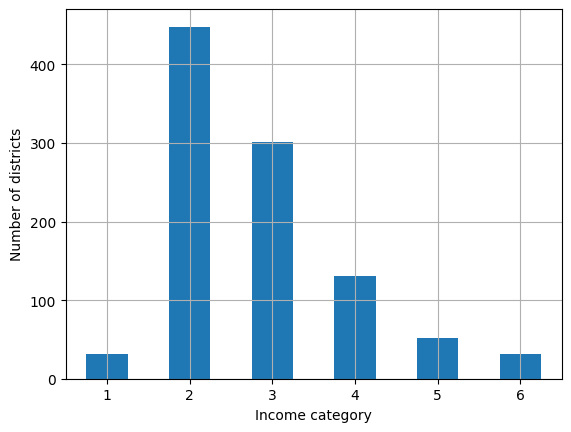

In [29]:
house["meter_cat"] = pd.cut(house["meter"],
bins=[0., 40, 80, 120, 160, 200., np.inf],
labels=[1, 2, 3, 4, 5, 6])
house["meter_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
# plt.show()

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
stratSplits = []
for trainIndex, testIndex in splitter.split(house, house["meter_cat"]):
    stratTrainSetN = house.iloc[trainIndex]
    stratTestSetN = house.iloc[testIndex]
    stratSplits.append([stratTrainSetN, stratTestSetN])
    
stratTrainSet, stratTestSet = stratSplits[0]
print(stratTestSet["meter_cat"].value_counts() / len(stratTestSet))

2    0.452261
3    0.301508
4    0.130653
5    0.055276
1    0.030151
6    0.030151
Name: meter_cat, dtype: float64


In [31]:
stratTrainSet, stratTestSet = stratSplits[0]
print(stratTestSet["meter_cat"].value_counts() / len(stratTestSet))

2    0.452261
3    0.301508
4    0.130653
5    0.055276
1    0.030151
6    0.030151
Name: meter_cat, dtype: float64


In [32]:
for set_ in ( stratTrainSet ,stratTestSet):
    set_.drop("meter_cat", axis=1 , inplace=True)

/tmp/ipykernel_19290/117964952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("meter_cat", axis=1 , inplace=True)
/tmp/ipykernel_19290/117964952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("meter_cat", axis=1 , inplace=True)


_**START of the MODEL pre-process**_

In [33]:
house = stratTrainSet.copy()
corr_matrix = house.corr()
print(corr_matrix['price'].sort_values(ascending=False))

price        1.000000
meter        0.789916
rooms        0.552317
space        0.199410
elevator     0.198411
buildYear    0.128616
parking      0.115500
floor        0.050503
age         -0.128616
Name: price, dtype: float64


/tmp/ipykernel_19290/3448244544.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = house.corr()


_note 1_ : wow it seems that meter is really important!

In [34]:
house = stratTrainSet.drop('price',axis=1)
labels = stratTrainSet['price'].copy()


imputation

In [35]:
def imputeFrequent(cols,h):
    for col in cols:
        frequent = house[col].mode()
        h[[col]]=h[[col]].fillna(float(frequent),inplace=False)
    return h
house = imputeFrequent(['floor','rooms','meter','buildYear'], house)
house.describe()


,meter,buildYear,rooms,elevator,space,parking,floor,age
count,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000
mean,95.719497,1393.215094,1.938365,0.781132,0.838994,0.928302,3.801258,9.784906
std,50.729023,8.099524,0.734178,0.413739,0.367768,0.258150,3.318257,8.099524
min,1.000000,1370.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,62.000000,1386.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
50%,83.000000,1395.000000,2.000000,1.000000,1.000000,1.000000,3.000000,8.000000
75%,115.000000,1401.000000,2.000000,1.000000,1.000000,1.000000,4.000000,17.000000
max,480.000000,1403.000000,4.000000,1.000000,1.000000,1.000000,27.000000,33.000000


*Handling district*

In [36]:
from sklearn.preprocessing import OneHotEncoder
houseCategory=house[['district']]
housingOneHot = OneHotEncoder().fit_transform(houseCategory)
housingOneHot.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

number attributes:

In [37]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
houseNum=house.select_dtypes(np.number)
housingNumStd = std_scaler.fit_transform(houseNum)

from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(house[["meter"]])

**And finally The PIPELINE**

In [38]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
("impute", SimpleImputer(strategy='most_frequent')),
("standardize", StandardScaler()),
])
houseNumPrepared=num_pipeline.fit_transform(houseNum)
cat_pipeline = make_pipeline(
SimpleImputer(strategy="most_frequent"),
OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ('cat',cat_pipeline,['district'])
],remainder=num_pipeline)
housing_prepared = preprocessing.fit_transform(house)


**Train**

In [39]:
from sklearn.tree import DecisionTreeRegressor
reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=7))
reg.fit(house,labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                              SimpleImputer(strategy='most_frequent')),
                                                             ('standardize',
                                                              StandardScaler())]),
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['district'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=7))])

**Result**
Linear regression: 5.641 rmse (wait, what? underFitting!)
Decision tree: 0.01 rmse (wait, what? overFitting!)

In [40]:
housing_predictions = reg.predict(house)
print(housing_predictions[:5]/1000000000)
print(labels.iloc[:5].values/1000000000)

[1.2250e-08 2.4375e-08 1.4500e-08 1.5500e-08 7.1500e-08]
[1.2250e-08 2.4375e-08 1.4500e-08 1.5500e-08 7.1500e-08]


In [41]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(labels, housing_predictions,squared=False)
print(rmse/1000000000)# in billion

1.1509498401716711e-10


**Really, Really Testing for overfitting**

In [42]:
from sklearn.model_selection import cross_val_score
realRMSE = -cross_val_score(reg, house, labels,
scoring="neg_root_mean_squared_error", cv=10)
pd.Series(realRMSE).describe() 

count    10.000000
mean      9.811012
std       4.077373
min       3.979829
25%       6.622929
50%       8.563117
75%      13.693989
max      15.178471
dtype: float64

In [43]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = make_pipeline(preprocessing,
RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, house, labels,
scoring="neg_root_mean_squared_error", cv=10)

In [45]:
pd.Series(forest_rmses).describe()


count    10.000000
mean      8.431710
std       3.916901
min       4.334441
25%       5.440258
50%       6.437087
75%      11.719925
max      15.096919
dtype: float64